In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib as im
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from skimage.transform import resize
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
%matplotlib inline

random.seed(42)

model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")

In [89]:
def control(path, file):
    """
    Returns a dictionary of errors for the given file without sharpening.
    
    Parameter path: The path to the given file
    Precondition: path is a string
    
    Parameter file: The file to evaluate the error of
    Precondition: file is a string
    """
    img = np.load(path + file)
    height, width = img.shape
    smallimg = resize(img, (round(height/2), round(width/2)))
    control = resize(smallimg, (height, width))
    mae = mean_absolute_error(img, control)
    rmse = mean_squared_error(img, control, squared=False)
    return {'File': file, 'Band': file[19:21], 'Control_MAE': mae, 'Control_RMSE': rmse}

def load_image(path):
    """
    Returns loaded .npy file.
    
    Parameter path: Path to load .npy file from
    Precondition: path is a string
    """
    array = np.load(path)
    result = np.zeros((array.shape[0], array.shape[1], 3))
    result[:,:,0]= array
    result[:,:,1]= array
    result[:,:,2]= array
    result = result.astype('uint8')
    return result

def preprocess_image(array):
    """
    Returns preprocessed input array.
    
    Parameter array: array to preprocess
    Precondition: array is a numpy array
    """
    hr_image = array
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 2) * 2
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def downscale_image(image):
    """
    Returns low resolution image after scaling down input image using nearest neighbor downsampling.

    Parameter image: 3D of 4D tensor of preprocessed image
    Precondition: image is a tensor
    """
    image_size = []
    if len(image.shape) == 3:
        image_size = [image.shape[1], image.shape[0]]
    else:
        raise ValueError("Dimension mismatch. Can work only on single image.")

    image = tf.squeeze(tf.cast(image, tf.uint8))

    lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 2, image_size[1] // 2]))
    lr_image = tf.expand_dims(lr_image, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

In [77]:
path = '../../GOES_Files/npy_files/'
file = random.choice(os.listdir(path))
image = load_image(path + file)
hr_image = preprocess_image(image)
lr_image = downscale_image(tf.squeeze(hr_image))
print('LR initial shape: {}'.format(lr_image.shape))
fake_image = model(lr_image)
print('HF initial shape: {}'.format(fake_image.shape))
fake_image = tf.squeeze(fake_image)

LR initial shape: (1, 250, 250, 3)
HF initial shape: (1, 1000, 1000, 3)


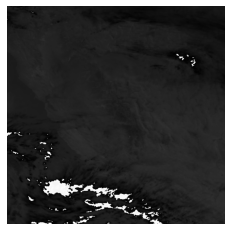

In [78]:
plt.imshow(image, aspect='equal', cmap='Greens')
plt.axis('off')
plt.show()

In [69]:
img = np.load(path + file)
height, width = img.shape
smallimg = resize(img, (round(height/2), round(width/2)))
control = resize(smallimg, (height, width))
mae = mean_absolute_error(img, control)
rmse = mean_squared_error(img, control, squared=False)
# return {'File': file, 'Band': file[19:21], 'Control_MAE': mae, 'Control_RMSE': rmse}

In [84]:
hr_image = tf.squeeze(hr_image).numpy()[:,:,0]
lr_image = tf.squeeze(tf.cast(lr_image, tf.uint8))
lr_image = np.asarray(Image.fromarray(tf.squeeze(lr_image).numpy()).resize([hr_image.shape[0], hr_image.shape[1]]))[:,:,0]
fake_image = resize(fake_image.numpy()[:,:,0], [hr_image.shape[0], hr_image.shape[1]])

print('LR final shape: {}'.format(lr_image.shape))
print('HF final shape: {}'.format(fake_image.shape))

control_mae = mean_absolute_error(hr_image, lr_image)
control_rmse = mean_squared_error(hr_image, lr_image, squared=False)

mae = mean_absolute_error(hr_image, fake_image)
rmse = mean_squared_error(hr_image, fake_image, squared=False)
df = {'File': file, 'Band': file[19:21], 'Control_MAE*': control_mae, 'Control_RMSE*': control_rmse, 'MAE': mae, 'RMSE': rmse}

LR final shape: (500, 500)
HF final shape: (500, 500)


/sharedData2/nshakoor/.conda/envs/fires/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


Text(0.5, 1.0, 'HR')

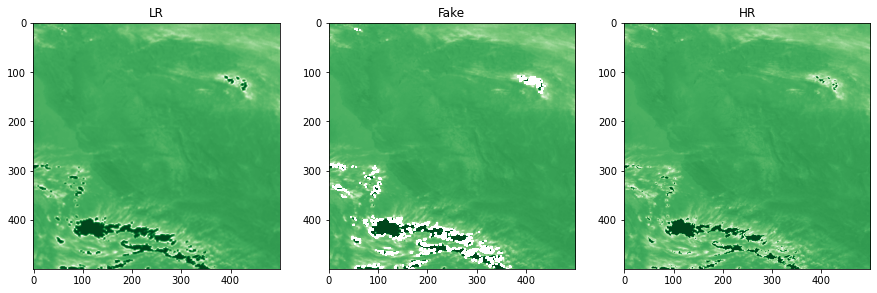

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
vmax = np.log(hr_image+1).max()
vmin = np.log(hr_image+1).min()

x = ax[0].imshow(np.log(lr_image*1.0+1), aspect='equal', cmap='Greens', vmax=vmax, vmin=vmin)
ax[0].set_title('LR')

x = ax[1].imshow(np.log(fake_image*1.0+1), aspect='equal', cmap='Greens', vmax=vmax, vmin=vmin)
ax[1].set_title('Fake')

x = ax[2].imshow(np.log(hr_image*1.0+1), aspect='equal', cmap='Greens', vmax=vmax, vmin=vmin)
ax[2].set_title('HR')

Text(0.5, 1.0, 'HR')

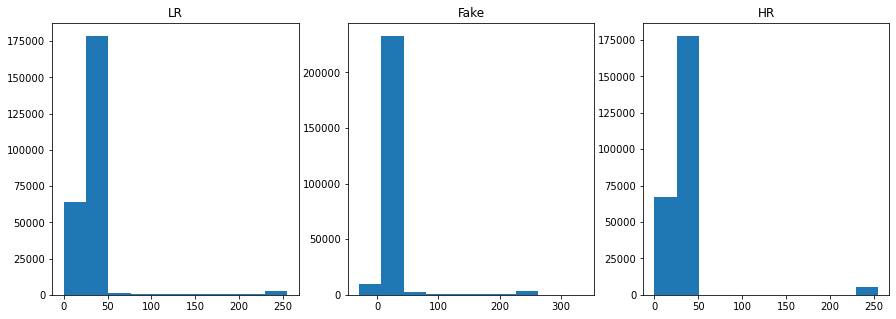

In [99]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

x = ax[0].hist(lr_image.ravel())
ax[0].set_title('LR')

x = ax[1].hist(fake_image.ravel())
ax[1].set_title('Fake')

x = ax[2].hist(hr_image.ravel())
ax[2].set_title('HR')

In [91]:
df

{'File': 'OR_ABI-L1b-RadC-M3C07_G17_s20183192302189_e20183192304573_c20183192305008.npy',
 'Band': '07',
 'Control_MAE*': 2.5281758,
 'Control_RMSE*': 10.909515,
 'MAE': 2.2511585,
 'RMSE': 7.3945727}

In [90]:
control(path, file)

{'File': 'OR_ABI-L1b-RadC-M3C07_G17_s20183192302189_e20183192304573_c20183192305008.npy',
 'Band': '07',
 'Control_MAE': 0.80756056,
 'Control_RMSE': 1.2071645}